<a href="https://colab.research.google.com/github/Sevethseal/ML_projects/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings, sys, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ Environment ready")


✅ Environment ready


In [3]:
# --- 1) DATA GENERATION --------------------------------------------------------
def generate_ecommerce_data():
    start_date = datetime(2022, 1, 1)
    end_date = datetime(2024, 1, 1)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")

    products = {
        "Product_A": {"base_price": 50, "base_demand": 100, "elasticity": -1.2, "seasonality": 1.0},
        "Product_B": {"base_price": 30, "base_demand": 150, "elasticity": -0.8, "seasonality": 1.2},
        "Product_C": {"base_price": 80, "base_demand": 80,  "elasticity": -1.5, "seasonality": 0.8},
    }

    rows = []
    for i, date in enumerate(dates):
        dow = date.weekday()
        month = date.month
        is_weekend = dow >= 5
        is_holiday = (month in [12, 1]) or (month == 7)

        temperature = 20 + 15 * np.sin(2 * np.pi * (date.timetuple().tm_yday - 80) / 365) + np.random.normal(0, 5)
        economic_index = 100 + 10 * np.sin(2 * np.pi * i / 365) + np.random.normal(0, 2)
        marketing_spend = np.random.exponential(500) if np.random.random() < 0.1 else np.random.exponential(50)

        for product, cfg in products.items():
            base_price = cfg["base_price"]
            price = max(base_price + np.random.normal(0, base_price * 0.1), base_price * 0.7)

            seasonal = (1 + 0.3 * np.sin(2 * np.pi * date.timetuple().tm_yday / 365 * cfg["seasonality"]))
            weekend = 1.2 if is_weekend else 1.0
            holiday = 1.5 if is_holiday else 1.0
            marketing = 1 + (marketing_spend / 1000) * 0.1
            weather = 1 + 0.002 * (25 - abs(temperature - 25))
            price_factor = (base_price / price) ** abs(cfg["elasticity"])

            demand = (cfg["base_demand"] * seasonal * weekend * holiday *
                      marketing * weather * price_factor * (economic_index / 100))
            demand = max(0, int(demand + np.random.normal(0, max(1, demand * 0.1))))

            rows.append({
                "date": date,
                "product_id": product,
                "demand": demand,
                "price": round(price, 2),
                "temperature": round(temperature, 1),
                "is_weekend": is_weekend,
                "is_holiday": is_holiday,
                "marketing_spend": round(marketing_spend, 2),
                "economic_index": round(economic_index, 2),
                "day_of_week": dow,
                "month": month,
                "quarter": (month - 1) // 3 + 1,
            })
    return pd.DataFrame(rows)

print("🔄 Generating data...")
df = generate_ecommerce_data()
print(f"✅ Data: {df.shape[0]} rows x {df.shape[1]} cols | {df['date'].min().date()} → {df['date'].max().date()}")

# Small peek
display(df.head(3))

# Save raw
df.to_csv("/content/ecommerce_synthetic_data.csv", index=False)

🔄 Generating data...
✅ Data: 2193 rows x 12 cols | 2022-01-01 → 2024-01-01


,date,product_id,demand,price,temperature,is_weekend,is_holiday,marketing_spend,economic_index,day_of_week,month,quarter
0,2022-01-01,Product_A,184,48.83,7.8,True,True,45.65,99.72,5,1,1
1,2022-01-01,Product_B,264,34.74,7.8,True,True,45.65,99.72,5,1,1
2,2022-01-01,Product_C,166,76.24,7.8,True,True,45.65,99.72,5,1,1


In [4]:
# --- 2) FEATURE ENGINEERING (LEAN) --------------------------------------------
def create_lag_features(df, target_col="demand", lags=(1, 7, 14, 30)):
    out = df.copy()
    for p in df["product_id"].unique():
        mask = out["product_id"] == p
        srt = out.loc[mask].sort_values("date")
        for L in lags:
            out.loc[mask, f"{target_col}_lag_{L}"] = srt[target_col].shift(L).values
    return out

def create_rolling_features(df, target_col="demand", windows=(7, 14, 30)):
    out = df.copy()
    for p in df["product_id"].unique():
        mask = out["product_id"] == p
        srt = out.loc[mask].sort_values("date")
        for w in windows:
            out.loc[mask, f"{target_col}_rolling_mean_{w}"] = srt[target_col].rolling(w).mean().values
            out.loc[mask, f"{target_col}_rolling_std_{w}"]  = srt[target_col].rolling(w).std().values
    return out

def create_price_features(df):
    out = df.copy()
    for p in df["product_id"].unique():
        mask = out["product_id"] == p
        srt = out.loc[mask].sort_values("date")
        out.loc[mask, "price_ma_7"] = srt["price"].rolling(7).mean().values
        out.loc[mask, "price_ma_30"] = srt["price"].rolling(30).mean().values
        out.loc[mask, "price_vs_ma_7"] = (srt["price"] / srt["price"].rolling(7).mean()).values
        out.loc[mask, "price_change"] = srt["price"].diff().values
        out.loc[mask, "price_change_pct"] = srt["price"].pct_change().values
    return out

def create_cyclical_features(df):
    out = df.copy()
    out["day_of_week_sin"] = np.sin(2 * np.pi * out["day_of_week"] / 7)
    out["day_of_week_cos"] = np.cos(2 * np.pi * out["day_of_week"] / 7)
    out["month_sin"] = np.sin(2 * np.pi * (out["month"] - 1) / 12)
    out["month_cos"] = np.cos(2 * np.pi * (out["month"] - 1) / 12)
    out["day_of_year"] = out["date"].dt.dayofyear
    out["day_of_year_sin"] = np.sin(2 * np.pi * out["day_of_year"] / 365)
    out["day_of_year_cos"] = np.cos(2 * np.pi * out["day_of_year"] / 365)
    return out

def create_interaction_features(df):
    out = df.copy()
    out["is_weekend_int"] = out["is_weekend"].astype(int)
    out["is_holiday_int"] = out["is_holiday"].astype(int)
    out["price_marketing_interaction"] = out["price"] * out["marketing_spend"]
    out["temp_season_interaction"] = out["temperature"] * out["month_sin"]
    out["weekend_holiday_interaction"] = out["is_weekend_int"] * out["is_holiday_int"]
    out["price_change_economic"] = out["price_change"] * out["economic_index"]
    return out

print("🔧 Engineering features...")
df_fe = (df
         .pipe(create_lag_features)
         .pipe(create_rolling_features)
         .pipe(create_price_features)
         .pipe(create_cyclical_features)
         .pipe(create_interaction_features)
        )

# Encode product
le = LabelEncoder()
df_fe["product_id_encoded"] = le.fit_transform(df_fe["product_id"])

# Handle missing via groupwise ffill/bfill
feature_cols_all = [c for c in df_fe.columns if c not in ["date", "product_id", "demand"]]
df_fe = df_fe.sort_values(["product_id", "date"])
df_fe[feature_cols_all] = df_fe.groupby("product_id")[feature_cols_all].apply(lambda g: g.ffill().bfill()).values

print("✅ Features ready:", len(feature_cols_all), "columns")
df_fe.to_csv("/content/ecommerce_features_engineered.csv", index=False)


# --- 3) TRAIN/TEST SPLIT (TIME-AWARE) -----------------------------------------
df_model = df_fe.dropna().sort_values(["date", "product_id"]).reset_index(drop=True)
exclude = ["date", "product_id", "demand"]
X_cols = [c for c in df_model.columns if c not in exclude]
split_idx = int(len(df_model) * 0.8)
train, test = df_model.iloc[:split_idx], df_model.iloc[split_idx:]

X_train, y_train = train[X_cols], train["demand"]
X_test,  y_test  = test[X_cols],  test["demand"]

# Scale only for linear models
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"📅 Train: {train['date'].min().date()} → {train['date'].max().date()} | Test: {test['date'].min().date()} → {test['date'].max().date()}")
print(f"📊 Train n={len(train):,} | Test n={len(test):,} | Features={len(X_cols)}")

🔧 Engineering features...
✅ Features ready: 38 columns
📅 Train: 2022-01-01 → 2023-08-08 | Test: 2023-08-08 → 2024-01-01
📊 Train n=1,754 | Test n=439 | Features=38


In [7]:
# --- 4) MODELS & EVALUATION ----------------------------------------------------
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate(model, Xtr, ytr, Xte, yte, name):
    model.fit(Xtr, ytr)
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "model": name,
        "train_mae": mean_absolute_error(ytr, yhat_tr),
        "test_mae": mean_absolute_error(yte, yhat_te),
        "train_rmse": math.sqrt(mean_squared_error(ytr, yhat_tr)),
        "test_rmse": math.sqrt(mean_squared_error(yte, yhat_te)),
        "train_r2": r2_score(ytr, yhat_tr),
        "test_r2": r2_score(yte, yhat_te),
        "train_mape": safe_mape(ytr, yhat_tr),
        "test_mape": safe_mape(yte, yhat_te),
    }, yhat_te

models = {
    "Linear Regression": (LinearRegression(), X_train_s, X_test_s),
    "Ridge Regression":  (Ridge(alpha=1.0), X_train_s, X_test_s),
    "Lasso Regression":  (Lasso(alpha=0.1), X_train_s, X_test_s),
    "Random Forest":     (RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1), X_train, X_test),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), X_train, X_test),
}

print("🚀 Training models...")
results, preds = [], {}
for name, (mdl, Xtr, Xte) in models.items():
    metrics, yhat = evaluate(mdl, Xtr, y_train, Xte, y_test, name)
    results.append(metrics)
    preds[name] = yhat
print("✅ Done.")

results_df = pd.DataFrame(results).sort_values("test_rmse")
display(results_df.round(3))

🚀 Training models...
✅ Done.


,model,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2,train_mape,test_mape
4,Gradient Boosting,9.763,10.116,12.664,14.992,0.956,0.943,7.075,9.527
3,Random Forest,5.165,10.665,7.158,15.088,0.986,0.942,3.584,10.335
0,Linear Regression,13.697,12.204,18.249,16.478,0.909,0.931,9.996,12.339
1,Ridge Regression,13.704,12.307,18.259,16.538,0.909,0.931,10.017,12.495
2,Lasso Regression,13.837,12.772,18.481,16.935,0.907,0.927,10.182,13.253


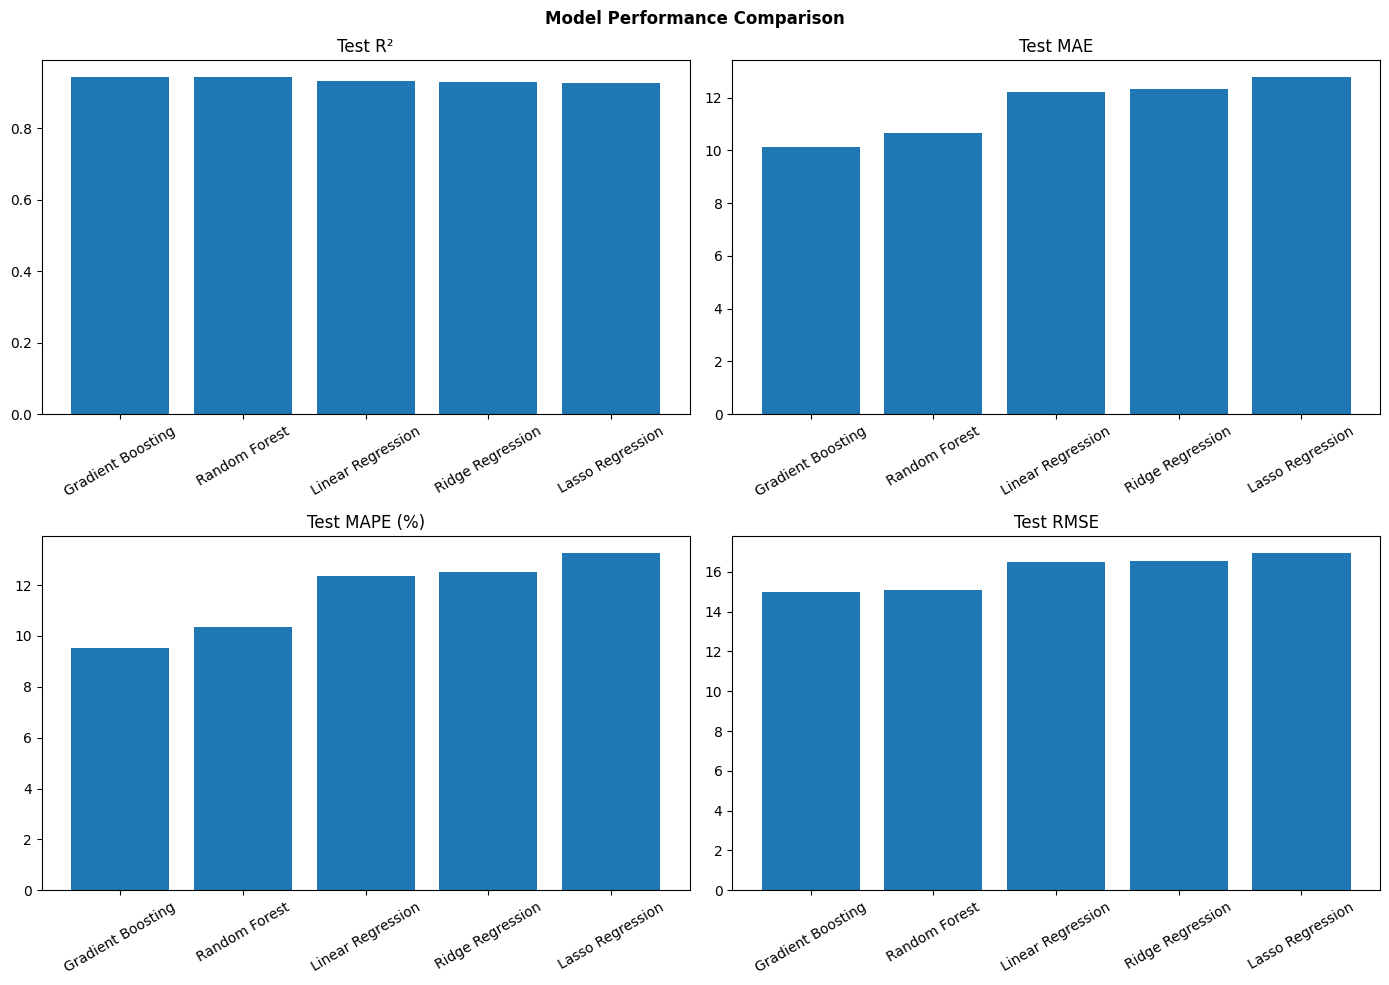

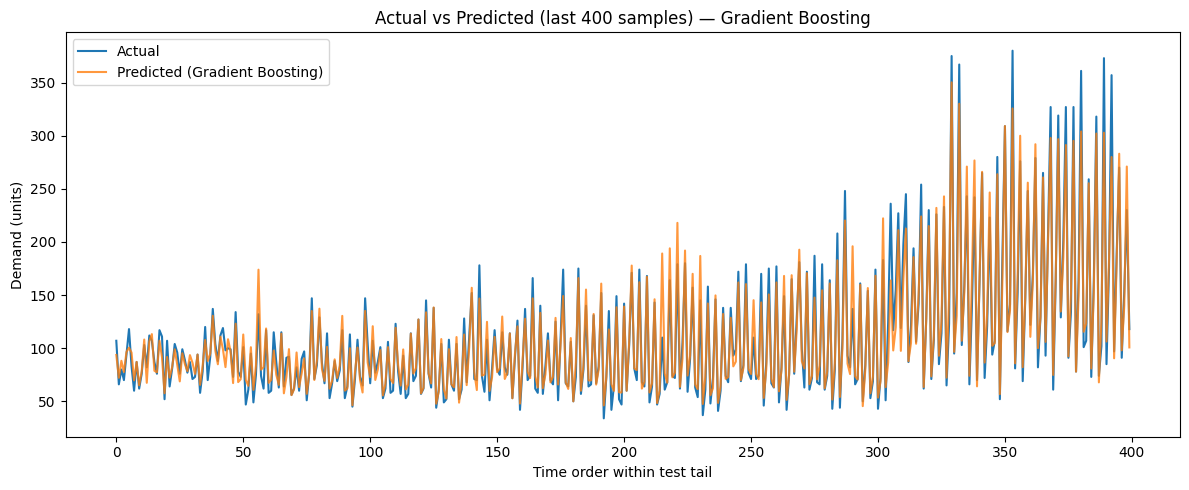

🎉 Complete!
Files saved:
- /content/ecommerce_synthetic_data.csv
- /content/ecommerce_features_engineered.csv


In [8]:
# --- 5) VISUALS (LEAN) --------------------------------------------------------
# Bar charts: R2, MAE, MAPE, RMSE
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Performance Comparison", fontweight="bold")

axes[0,0].bar(results_df["model"], results_df["test_r2"])
axes[0,0].set_title("Test R²"); axes[0,0].tick_params(axis="x", rotation=30)

axes[0,1].bar(results_df["model"], results_df["test_mae"])
axes[0,1].set_title("Test MAE"); axes[0,1].tick_params(axis="x", rotation=30)

axes[1,0].bar(results_df["model"], results_df["test_mape"])
axes[1,0].set_title("Test MAPE (%)"); axes[1,0].tick_params(axis="x", rotation=30)

axes[1,1].bar(results_df["model"], results_df["test_rmse"])
axes[1,1].set_title("Test RMSE"); axes[1,1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# Pick best by RMSE and plot Actual vs Predicted (tail for readability)
best_name = results_df.iloc[0]["model"]
best_pred = preds[best_name]
tail_n = 400  # show last N points to keep it readable
y_true_tail = y_test.values[-tail_n:]
y_pred_tail = best_pred[-tail_n:]

plt.figure(figsize=(12,5))
plt.plot(y_true_tail, label="Actual")
plt.plot(y_pred_tail, label=f"Predicted ({best_name})", alpha=0.8)
plt.title(f"Actual vs Predicted (last {tail_n} samples) — {best_name}")
plt.xlabel("Time order within test tail"); plt.ylabel("Demand (units)")
plt.legend()
plt.tight_layout()
plt.show()

print("🎉 Complete!")
print("Files saved:")
print("- /content/ecommerce_synthetic_data.csv")
print("- /content/ecommerce_features_engineered.csv")